In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import scipy as sp
import scipy.linalg
from pathlib import Path
from collections import defaultdict

from regdpp.general import ROOT_DIR
from regdpp.sample import RegDPP
from regdpp.utils import load_libsvm_data
from regdpp.metrics import A_opt_criterion
from regdpp.sdp import get_optimal_weights


In [2]:
data_dir = Path(ROOT_DIR, 'data')

In [3]:
dataset = "mg_scale"

In [4]:
X = load_libsvm_data(dataset)

In [5]:
n, d = X.shape

In [6]:
k_range = np.arange(d, 5*d, 3)
n_repeat = 5
A_criteria = defaultdict(lambda : np.empty((len(k_range), n_repeat)))

In [7]:
config = {
    "methods":
        {
            "plain_reg_dpp":
                {
                    "name": "Reg DPP w/o SDP",
                    "sdp": False
                },
            "reg_dpp_sdp":
                {
                    "name": "Reg DPP w/ SDP",
                    "sdp": True
                }
        }
}

In [11]:
# from tqdm import tqdm
from tqdm.notebook import trange, tqdm

for method, params in config["methods"].items():
    for k_id, k in tqdm(list(enumerate(k_range))):
        print(f'Looking for subset of size {k}')
        A = 1./n * np.eye(d)

        if "reg_dpp" in method:
            sampler = RegDPP()
            if params["sdp"]:
                p = get_optimal_weights(X, A, k)
            else:
                p = np.ones(n) * k / n
        else:
            raise KeyError("sampler undefined")

        for rep_id in trange(n_repeat):
            S = sampler(X, A, p)

            X_S = X[S]
            subset_cov = X_S.T @ X_S
            A_optimal_criterium = A_opt_criterion(subset_cov, A)
            A_criteria[params["name"]][k_id, rep_id] = A_optimal_criterium
        print(f'Time of sampling: {np.mean(sampler.time_cnts):.3f} +- {1.96 * np.std(sampler.time_cnts):.3f}')


  0%|          | 0/8 [00:00<?, ?it/s]

Looking for subset of size 6


  0%|          | 0/5 [00:00<?, ?it/s]

Time of sampling: 0.580 +- 0.176
Looking for subset of size 9


  0%|          | 0/5 [00:00<?, ?it/s]

Time of sampling: 0.522 +- 0.138
Looking for subset of size 12


  0%|          | 0/5 [00:00<?, ?it/s]

Time of sampling: 0.675 +- 0.422
Looking for subset of size 15


  0%|          | 0/5 [00:00<?, ?it/s]

Time of sampling: 0.567 +- 0.153
Looking for subset of size 18


  0%|          | 0/5 [00:00<?, ?it/s]

Time of sampling: 0.535 +- 0.288
Looking for subset of size 21


  0%|          | 0/5 [00:00<?, ?it/s]

Time of sampling: 0.521 +- 0.202
Looking for subset of size 24


  0%|          | 0/5 [00:00<?, ?it/s]

Time of sampling: 0.465 +- 0.103
Looking for subset of size 27


  0%|          | 0/5 [00:00<?, ?it/s]

Time of sampling: 0.484 +- 0.141


  0%|          | 0/8 [00:00<?, ?it/s]

Looking for subset of size 6


  0%|          | 0/5 [00:00<?, ?it/s]

Time of sampling: 0.674 +- 0.196
Looking for subset of size 9


  0%|          | 0/5 [00:00<?, ?it/s]

Time of sampling: 0.811 +- 0.198
Looking for subset of size 12


  0%|          | 0/5 [00:00<?, ?it/s]

Time of sampling: 0.897 +- 0.953
Looking for subset of size 15


  0%|          | 0/5 [00:00<?, ?it/s]

Time of sampling: 1.113 +- 1.043
Looking for subset of size 18


  0%|          | 0/5 [00:00<?, ?it/s]

Time of sampling: 0.879 +- 0.791
Looking for subset of size 21


  0%|          | 0/5 [00:00<?, ?it/s]

Time of sampling: 0.684 +- 0.328
Looking for subset of size 24


  0%|          | 0/5 [00:00<?, ?it/s]

Time of sampling: 0.553 +- 0.116
Looking for subset of size 27


  0%|          | 0/5 [00:00<?, ?it/s]

Time of sampling: 0.537 +- 0.222


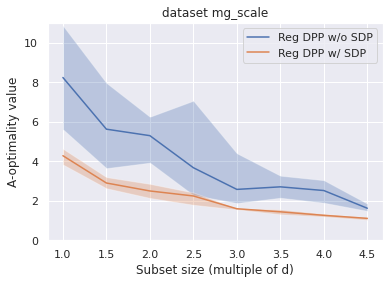

In [12]:
from matplotlib import pyplot as plt
import seaborn as sns
from scipy import stats

sns.set_theme()

for name, a_value in A_criteria.items():
    plt.plot(k_range / d, a_value.mean(1), label=name)

    ci = stats.bootstrap((a_value.T,), np.mean, axis=0, confidence_level=0.95).confidence_interval
    plt.fill_between(k_range / d, ci.low, ci.high, alpha=0.3)

plt.ylim(0, 11)
plt.xlabel('Subset size (multiple of d)')
plt.ylabel('A-optimality value')
plt.title(f'dataset {dataset}')
plt.legend()
plt.show()